In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

# Dane

In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [3]:
data.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


In [4]:
num_feature1 = 'w6_q24_length'  # length of q24 how met answer in characters
num_feature2 = 'w6_q21b_year'  # year subject began romantic relationship with partner
cat_feature1 = 'w6_q34'  # how would you describe the quality of your relationship with partner?
cat_feature2 = 'w6_otherdate_dichotomous'  # did subject meet someone last year (other than current partner)?
label = 'S1'  # Are you married?

In [5]:
data[num_feature1].describe()

count    3394.000000
mean      182.854446
std       236.993301
min         0.000000
25%        54.000000
50%       124.000000
75%       222.750000
max      3855.000000
Name: w6_q24_length, dtype: float64

In [6]:
data[num_feature2].describe()

count    3276.000000
mean     1995.875153
std        16.741519
min      1942.000000
25%      1983.000000
50%      2000.000000
75%      2010.000000
max      2017.000000
Name: w6_q21b_year, dtype: float64

In [7]:
data[cat_feature1].describe()

count          2856
unique            6
top       Excellent
freq           1706
Name: w6_q34, dtype: object

In [8]:
data[cat_feature2].describe()

count     3363
unique       2
top         no
freq      3034
Name: w6_otherdate_dichotomous, dtype: object

In [9]:
data[cat_feature1].unique()

[NaN, Excellent, Good, Fair, Very Poor, Poor, Refused]
Categories (6, object): [Refused < Excellent < Good < Fair < Poor < Very Poor]

In [10]:
data[cat_feature2].unique()

[yes, no, NaN]
Categories (2, object): [no < yes]

In [11]:
data[label].describe()

count                  3510
unique                    2
top       Yes, I am Married
freq                   2085
Name: S1, dtype: object

In [12]:
data[label].unique()

[No, I am not Married, Yes, I am Married]
Categories (2, object): [Yes, I am Married < No, I am not Married]

In [16]:
le1 = LabelEncoder()
le2 = LabelEncoder()
df = data[[num_feature1, num_feature2, cat_feature1, cat_feature2, label]]
df = df.dropna()
encoded_cat1 = le1.fit_transform(df[cat_feature1])
encoded_cat2 = le2.fit_transform(df[cat_feature2])
df[cat_feature1] = encoded_cat1
df[cat_feature2] = encoded_cat2
df[label] = df[label].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
df.head()

,w6_q24_length,w6_q21b_year,w6_q34,w6_otherdate_dichotomous,S1
1,213.0,1995.0,0,0,1
2,87.0,2006.0,2,0,1
4,648.0,1983.0,0,0,1
5,107.0,1982.0,2,0,1
6,111.0,1967.0,0,0,1


In [17]:
df.describe()

,w6_q24_length,w6_q21b_year,w6_q34,w6_otherdate_dichotomous
count,2745.000000,2745.000000,2745.000000,2745.000000
mean,191.167572,1995.526047,0.767942,0.079781
std,244.233276,16.638284,1.019343,0.271004
min,0.000000,1942.000000,0.000000,0.000000
25%,61.000000,1983.000000,0.000000,0.000000
50%,130.000000,1999.000000,0.000000,0.000000
75%,231.000000,2010.000000,2.000000,0.000000
max,3855.000000,2017.000000,5.000000,1.000000


# Model

In [65]:
X = df.drop(label, axis=1)
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
model = XGBClassifier()
model.fit(X_train.values, y_train.values)
pred_y = model.predict(X_test.values)
score = accuracy_score(pred_y, y_test.values)
print(f'Accuracy: {score}')

Accuracy: 0.8296943231441049


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Wykresy ceteris paribus

In [81]:
def ceteris_paribus(model, sample, feature, features):
    i = df.columns.get_loc(feature)
    min_value = min(features[:,i])
    max_value = max(features[:,i])
    x = np.linspace(min_value,max_value,len(np.unique(features[:,i])))
    x_to_predict = np.tile(sample,(len(np.unique(features[:,i])), 1))
    x_to_predict[:,i] = x
    y = model.predict_proba(x_to_predict)[:,1]
    sample_pred = model.predict_proba(sample)[0, 1]
    fig = plt.figure(figsize=(15, 10))
    plt.plot(x,y)
    plt.scatter(sample[0, i], sample_pred, c = 'red', s = 70)
    plt.xlabel(feature)
    plt.ylabel('Married probability')

In [82]:
sample = X_test.sample(1, random_state = 123)
print(sample)
sample = sample.values

      w6_q24_length  w6_q21b_year  w6_q34  w6_otherdate_dichotomous
2448          130.0        1981.0       0                         0


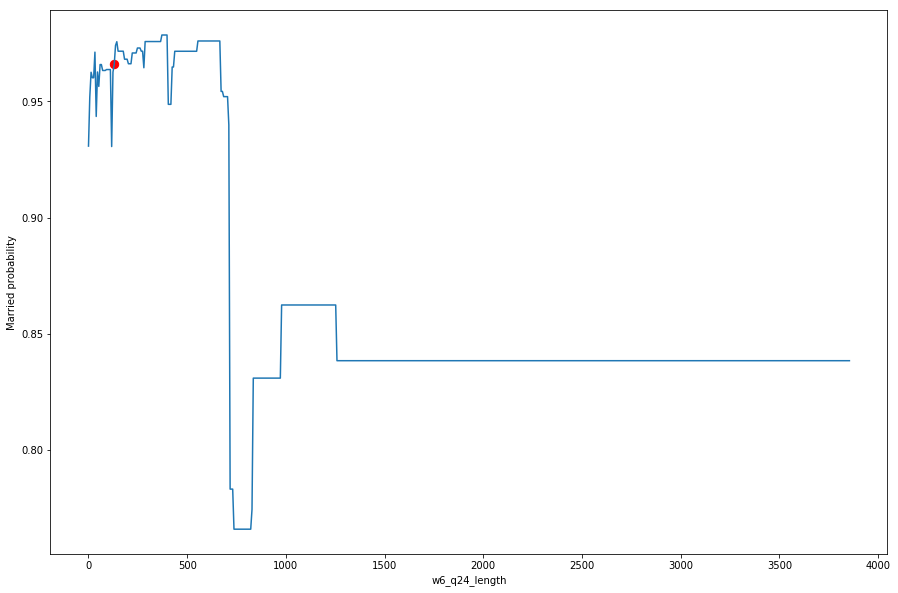

In [83]:
ceteris_paribus(model, sample, 'w6_q24_length', X.values)

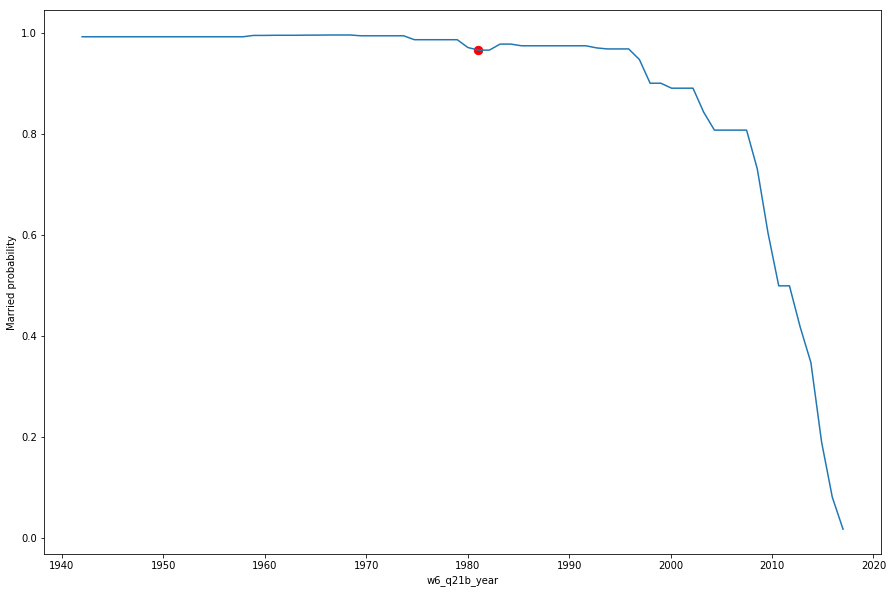

In [84]:
ceteris_paribus(model, sample, 'w6_q21b_year', X.values)